https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torchmetrics.image.fid import FrechetInceptionDistance
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import seaborn as sns
import wandb

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device Used: {device}")

Device Used: cuda


In [3]:
saved_model_folder = "./saved_models"
os.makedirs(saved_model_folder, exist_ok=True)

In [4]:
class AFHQDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir: path of the parent directory that contains images.
        transforms: augmentations applied to the images (can be none or more).
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_mapping = {}
        
        extensions = (".jpg", ".jpeg", ".png")
        # go through all sub-directories
        for label, category in enumerate(sorted(os.listdir(root_dir))):
            full_path = os.path.join(root_dir, category)
            if os.path.exists(full_path):
                self.class_mapping[label] = category
                for img_name in os.listdir(full_path):
                    if img_name.endswith(extensions):
                        self.image_paths.append(os.path.join(full_path, img_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [5]:
# Dataset Hyperparameters
img_size = 64
batch_size = 64

# dataset paths
train_dir = '/home/user/javeda1/stargan-v2/data/afhq/train'
val_dir = '/home/user/javeda1/stargan-v2/data/afhq/val'

In [6]:
transform = transforms.Compose([
    
        # transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
        transforms.Resize((img_size, img_size)), # image is downsampled to 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [7]:
# Load the train and val dataset
train_dataset = AFHQDataset(root_dir=train_dir, transform=transform)
val_dataset = AFHQDataset(root_dir=val_dir, transform=transform)

# DataLoaders for train and val sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

train_size = len(train_loader.dataset)
val_size = len(val_loader.dataset)

print(f"Train dataset size: {train_size}")
print(f"Validation dataset size: {val_size}")

Train dataset size: 14630
Validation dataset size: 1500


In [8]:
def visualize_dataset(dataloader, num_images=12):
    """
    Visualizes a given number of images from the given data loader.
    """
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    class_mapping = dataloader.dataset.class_mapping
    
    # creates a suitable grid
    # grid_size = int(np.ceil(np.sqrt(num_images)))
    num_rows = int(np.sqrt(num_images))
    num_cols = int(np.ceil(num_images / num_rows))
    # print(num_cols, num_rows)
    plt.figure(figsize=(6, 6))
    plt.suptitle("Sample images from AFHQ dataset")
    
    for idx in range(min(num_images, len(images))):
        plt.subplot(num_rows, num_cols, idx + 1)
        
        img = images[idx].permute(1, 2, 0).numpy()
        max_val = np.max(img)
        min_val = np.min(img)
        img = (img - min_val) / (max_val - min_val)
        
        plt.imshow(img)
        plt.title(f'Class: {class_mapping[labels[idx].item()]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

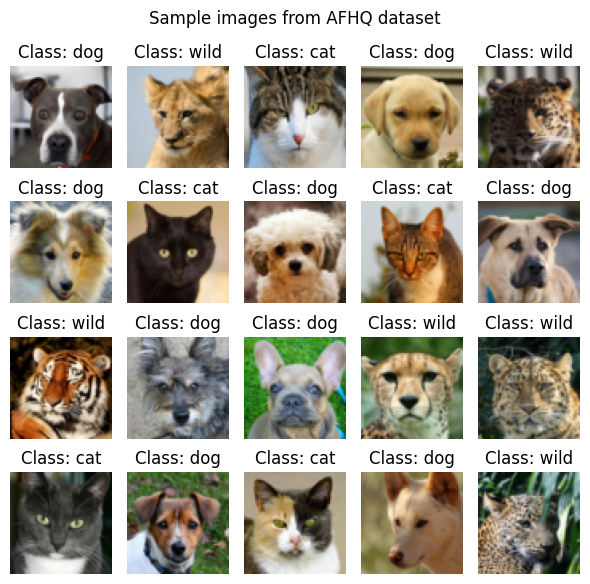

In [9]:
visualize_dataset(train_loader, num_images=20)

In [12]:
def compute_fid_score_gan(generator, data_loader, device, latent_dim=100, max_samples=1000):
    """
    Computes the Fréchet Inception Distance (FID) between real and generated images.
    """
    fid = FrechetInceptionDistance(feature=2048).to(device)
    generator.eval()
    
    total_samples = 0
    with torch.no_grad():
        for real_images, _ in data_loader:
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            
            # Generate fake images
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = generator(noise)
            
            # Convert images to uint8 and scale to [0, 255]
            real_images = (real_images * 0.5 + 0.5).clamp(0, 1)
            fake_images = (fake_images * 0.5 + 0.5).clamp(0, 1)
            real_images = (real_images * 255).byte()
            fake_images = (fake_images * 255).byte()
            
            fid.update(real_images, real=True)
            fid.update(fake_images, real=False)
            
            total_samples += batch_size
            if total_samples >= max_samples:
                break
    
    return fid.compute().item()


In [14]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, num_channels=3):
        super(Generator, self).__init__()
        
        # Initial dense projection from latent space
        self.fc = nn.Linear(latent_dim, 512 * 4 * 4)
        self.bn1 = nn.BatchNorm2d(512)
        self.relu1 = nn.ReLU(True)
        
        # Second block: 512 x 4 x 4 -> 256 x 8 x 8
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.conv2 = nn.Conv2d(512, 256, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.ReLU(True)
        
        # Third block: 256 x 8 x 8 -> 128 x 16 x 16
        self.upsample3 = nn.Upsample(scale_factor=2)
        self.conv3 = nn.Conv2d(256, 128, 3, 1, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(True)
        
        # Fourth block: 128 x 16 x 16 -> 64 x 32 x 32
        self.upsample4 = nn.Upsample(scale_factor=2)
        self.conv4 = nn.Conv2d(128, 64, 3, 1, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU(True)
        
        # Final block: 64 x 32 x 32 -> num_channels x 64 x 64
        self.upsample5 = nn.Upsample(scale_factor=2)
        self.conv5 = nn.Conv2d(64, num_channels, 3, 1, 1, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # Initial projection and reshape
        x = self.fc(x.view(-1, x.size(1)))
        x = x.view(-1, 512, 4, 4)
        x = self.bn1(x)
        x = self.relu1(x)
        
        # Second block
        x = self.upsample2(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        # Third block
        x = self.upsample3(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        
        # Fourth block
        x = self.upsample4(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        
        # Final block
        x = self.upsample5(x)
        x = self.conv5(x)
        x = self.tanh(x)
        
        return x

class Discriminator(nn.Module):
    def __init__(self, num_channels=3):
        super(Discriminator, self).__init__()
        
        # First convolution block
        self.conv1 = nn.Conv2d(num_channels, 64, 4, 2, 1, bias=False)
        self.lrelu1 = nn.LeakyReLU(0.2, inplace=True)
        
        # Second convolution block
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.lrelu2 = nn.LeakyReLU(0.2, inplace=True)
        
        # Third convolution block
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        self.lrelu3 = nn.LeakyReLU(0.2, inplace=True)
        
        # Fourth convolution block
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(512)
        self.lrelu4 = nn.LeakyReLU(0.2, inplace=True)
        
        # Final convolution
        self.conv5 = nn.Conv2d(512, 1, 4, 1, 0, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.lrelu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.lrelu2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.lrelu3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.lrelu4(x)
        
        x = self.conv5(x)
        x = self.sigmoid(x)
        
        return x.view(-1)

In [15]:
def train_dcgan(generator, discriminator, train_loader, device, num_epochs=100, 
                latent_dim=100, lr=0.0002, beta1=0.5, project="dcgan-training", name="dcgan_run"):
    """
    Train the DCGAN model and log metrics to WandB
    """
    # Initialize WandB
    wandb.init(project=project, name=name,
               config={
                   "learning_rate": lr,
                   "num_epochs": num_epochs,
                   "latent_dim": latent_dim,
                   "beta1": beta1
               })
    
    criterion = nn.BCELoss()
    g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
    
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)
    
    for epoch in tqdm(range(num_epochs)):
        generator.train()
        discriminator.train()
        
        running_d_loss = 0.0
        running_g_loss = 0.0
        
        for i, (real_images, _) in enumerate(train_loader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            
            # Train Discriminator
            d_optimizer.zero_grad()
            label_real = torch.ones(batch_size, device=device)
            label_fake = torch.zeros(batch_size, device=device)
            
            output_real = discriminator(real_images)
            d_loss_real = criterion(output_real, label_real)
            
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = generator(noise)
            output_fake = discriminator(fake_images.detach())
            d_loss_fake = criterion(output_fake, label_fake)
            
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()
            
            # Train Generator
            g_optimizer.zero_grad()
            output_fake = discriminator(fake_images)
            g_loss = criterion(output_fake, label_real)
            g_loss.backward()
            g_optimizer.step()
            
            running_d_loss += d_loss.item()
            running_g_loss += g_loss.item()
        
        # Generate sample images
        with torch.no_grad():
            fake_images = generator(fixed_noise)
            fake_grid = make_grid(fake_images * 0.5 + 0.5, normalize=True, pad_value=1, padding=10)
            real_images = next(iter(train_loader))[0][:64]
            real_grid = make_grid(real_images * 0.5 + 0.5, normalize=True, pad_value=1, padding=10)
        
        # Calculate average losses
        avg_d_loss = running_d_loss / len(train_loader)
        avg_g_loss = running_g_loss / len(train_loader)
        
        # Log metrics to WandB
        wandb.log({
            "epoch": epoch + 1,
            "discriminator_loss": avg_d_loss,
            "generator_loss": avg_g_loss,
            "real_images": wandb.Image(real_grid),
            "generated_images": wandb.Image(fake_grid)
        })
        
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Discriminator Loss: {avg_d_loss:.4f}")
        print(f"Generator Loss: {avg_g_loss:.4f}")
    
    wandb.finish()
    return generator, discriminator

In [17]:
# def train_dcgan(generator, discriminator, train_loader, device, num_epochs=100, 
#                 latent_dim=100, lr=0.0002, beta1=0.5, project="dcgan-training", name="dcgan_run"):
#     """
#     Train the DCGAN model and log metrics to WandB
#     """
#     # Initialize WandB
#     wandb.init(project=project, name=name,
#                config={
#                    "learning_rate": lr,
#                    "num_epochs": num_epochs,
#                    "latent_dim": latent_dim,
#                    "beta1": beta1
#                })
    
#     criterion = nn.BCELoss()
#     g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
#     d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
    
#     fixed_noise = torch.randn(64, latent_dim, device=device)
    
#     for epoch in tqdm(range(num_epochs)):
#         generator.train()
#         discriminator.train()
        
#         running_d_loss = 0.0
#         running_g_loss = 0.0
        
#         for i, (real_images, _) in enumerate(train_loader):
#             batch_size = real_images.size(0)
#             real_images = real_images.to(device)
            
#             # Train Discriminator
#             d_optimizer.zero_grad()
#             label_real = torch.ones(batch_size, device=device)
#             label_fake = torch.zeros(batch_size, device=device)
            
#             output_real = discriminator(real_images)
#             d_loss_real = criterion(output_real, label_real)
            
#             noise = torch.randn(batch_size, latent_dim, device=device)
#             fake_images = generator(noise)
#             output_fake = discriminator(fake_images.detach())
#             d_loss_fake = criterion(output_fake, label_fake)
            
#             d_loss = d_loss_real + d_loss_fake
#             d_loss.backward()
#             d_optimizer.step()
            
#             # Train Generator
#             g_optimizer.zero_grad()
#             output_fake = discriminator(fake_images)
#             g_loss = criterion(output_fake, label_real)
#             g_loss.backward()
#             g_optimizer.step()
            
#             running_d_loss += d_loss.item()
#             running_g_loss += g_loss.item()
            
#             # Optional: Add FID score computation every N steps
#             if i % 100 == 0:
#                 fid_score = compute_fid_score_gan(generator, train_loader, device, latent_dim)
#                 wandb.log({"fid_score": fid_score})
        
#         # Generate sample images
#         with torch.no_grad():
#             fake_images = generator(fixed_noise)
#             fake_grid = make_grid(fake_images * 0.5 + 0.5, normalize=True, pad_value=1, padding=10)
#             real_images = next(iter(train_loader))[0][:64]
#             real_grid = make_grid(real_images * 0.5 + 0.5, normalize=True, pad_value=1, padding=10)
        
#         # Calculate average losses
#         avg_d_loss = running_d_loss / len(train_loader)
#         avg_g_loss = running_g_loss / len(train_loader)
        
#         # Log metrics to WandB
#         wandb.log({
#             "epoch": epoch + 1,
#             "discriminator_loss": avg_d_loss,
#             "generator_loss": avg_g_loss,
#             "real_images": wandb.Image(real_grid),
#             "generated_images": wandb.Image(fake_grid)
#         })
        
#         print(f"\nEpoch {epoch+1}/{num_epochs}")
#         print(f"Discriminator Loss: {avg_d_loss:.4f}")
#         print(f"Generator Loss: {avg_g_loss:.4f}")
    
#     wandb.finish()
#     return generator, discriminator

In [ ]:
# Initialize models
latent_dim = 100
generator = Generator(latent_dim=latent_dim).to(device)
discriminator = Discriminator().to(device)

# Train the models
generator, discriminator = train_dcgan(
    generator=generator,
    discriminator=discriminator,
    train_loader=train_loader,
    device=device,
    num_epochs=25,
    project="afhq-dcgan",
    name="dcgan_run"
)

  4%|██▏                                                     | 1/25 [00:09<03:41,  9.22s/it]


Epoch 1/25
Discriminator Loss: 0.6239
Generator Loss: 5.4067


  8%|████▍                                                   | 2/25 [00:18<03:34,  9.33s/it]


Epoch 2/25
Discriminator Loss: 0.5028
Generator Loss: 4.9822


 12%|██████▋                                                 | 3/25 [00:27<03:25,  9.33s/it]


Epoch 3/25
Discriminator Loss: 0.6248
Generator Loss: 4.0181


 16%|████████▉                                               | 4/25 [00:37<03:16,  9.35s/it]


Epoch 4/25
Discriminator Loss: 0.5585
Generator Loss: 4.2124


 20%|███████████▏                                            | 5/25 [00:46<03:07,  9.38s/it]


Epoch 5/25
Discriminator Loss: 0.5006
Generator Loss: 4.5521


 24%|█████████████▍                                          | 6/25 [00:55<02:57,  9.32s/it]


Epoch 6/25
Discriminator Loss: 0.4541
Generator Loss: 4.6201


 28%|███████████████▋                                        | 7/25 [01:05<02:48,  9.37s/it]


Epoch 7/25
Discriminator Loss: 0.4212
Generator Loss: 4.7552


 32%|█████████████████▉                                      | 8/25 [01:14<02:39,  9.35s/it]


Epoch 8/25
Discriminator Loss: 0.4211
Generator Loss: 4.5733


 36%|████████████████████▏                                   | 9/25 [01:23<02:28,  9.30s/it]


Epoch 9/25
Discriminator Loss: 0.3797
Generator Loss: 4.4085


 40%|██████████████████████                                 | 10/25 [01:33<02:19,  9.31s/it]


Epoch 10/25
Discriminator Loss: 0.3447
Generator Loss: 4.6344


 44%|████████████████████████▏                              | 11/25 [01:42<02:10,  9.29s/it]


Epoch 11/25
Discriminator Loss: 0.3362
Generator Loss: 4.6141


 48%|██████████████████████████▍                            | 12/25 [01:51<02:00,  9.26s/it]


Epoch 12/25
Discriminator Loss: 0.3206
Generator Loss: 4.8480


 52%|████████████████████████████▌                          | 13/25 [02:01<01:51,  9.29s/it]


Epoch 13/25
Discriminator Loss: 0.3180
Generator Loss: 4.8264


 56%|██████████████████████████████▊                        | 14/25 [02:10<01:42,  9.33s/it]


Epoch 14/25
Discriminator Loss: 0.3236
Generator Loss: 4.7566
